# Phase 2 : Creating Vectors and Implementing Data Balancing Techniques

In this phase, we build the vectors from the text using tf-idf and word2vec. The machine learning algorithms will be run on vectors created from both the methods and results will be compared for best vectorizer and algorithm combination.

### Importing Libraries

In [33]:
import numpy, pandas as pd, sklearn.feature_extraction.text as text
import sklearn.neighbors, sklearn.neural_network, sklearn.tree, sklearn.naive_bayes as nb, matplotlib.pyplot as plt, nltk, pickle, joblib

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE,ADASYN
from collections import Counter

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading processed data

* Replace the location from your g-drive location where the processed data file is saved.

In [35]:
location = '/content/drive/MyDrive/Colab Notebooks/MIS798_Files/MIS798_Project/Data_Files/'   # Parul
# location = '/content/drive/MyDrive/MIS798_SS/Pre_processed_data/'      # Uma
#location = '/content/drive/MyDrive/MIS798_Files/Pre_processed_data/'      # Nishu

data = 'Processed_data.csv'

df = pd.read_csv(location + data)
df.head()

,Text,Defect,Date
0,magic countertop powerful mixer category origi...,0,2017-08-29
1,magic countertop every speed work want peanut ...,0,2017-08-29
2,ingredient wrong work use unit definitive week...,1,2017-08-29
3,motor pick similar magic countertop two come t...,1,2017-08-29
4,magic countertop book amp shaver work follow m...,1,2017-08-29


### Data Split

In [36]:
X = df["Text"]
y = df["Defect"].astype('int')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [50]:
X_train.shape

(36018,)

In [38]:
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/MIS798_Files/MIS798_Project/Data_Files/X_train.csv', index = False)

### Tf-idf Vectorizer

In [39]:
tfidfvectorizer = tf(analyzer='word',stop_words= 'english')
x_train = tfidfvectorizer.fit_transform(X_train)
x_test = tfidfvectorizer.transform(X_test)

### Model Building

In [46]:
def models(clf, x_train,x_test, y_train, y_test, clf_name, save=False):
    """Fits and Predicts the models"""
    clf = clf.fit(x_train, y_train)
    # Prediction
    y_pred = clf.predict(x_test)
    
    precision, recall, accuracy = create_metrics(y_pred, clf_name, y_test)
    create_roc_curve(clf, clf_name, x_test, y_test)
    if save:
      save_model(clf, clf_name,'/content/drive/MyDrive/Colab Notebooks/MIS798_Files/MIS798_Project/Models/')
    return precision, recall, accuracy


def create_roc_curve(clf, clf_name, x_test, y_test):
  """ Generated the ROC curve"""
  # ROC Curve
  y_pred_prob = clf.predict_proba(x_test)[:, 1]
  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
  auc = round(metrics.roc_auc_score(y_test, y_pred_prob), 4)
  plt.plot(fpr,tpr,label=f"{clf_name}, AUC="+str(auc))

def create_metrics(y_predict, clf_name, y_test):
  """Calculates and prints the performance metrics of the model"""
  # Accuracy, Precesion, Recall
  accuracy = round(accuracy_score(y_test, y_predict)*100,2)
  precision = round(precision_score(y_test, y_predict) *100, 2)
  recall = round(recall_score(y_test, y_predict)*100,2)
  print("-"*20,clf_name,"-"*20)
      
  # Confusion Matrix
  print("Confusion Matrix")
  print(confusion_matrix(y_test, y_predict))
  print()
  print(classification_report(y_test, y_predict))

  return precision, recall, accuracy

def save_model(clf, clf_name, filename):
  """Saves the model"""
  # Saving models
  joblib.dump(clf, filename+clf_name+".joblib")


### Modeling Imbalanced Data using TF-idf Vectors

In [42]:
# Linear support vector classifier 
clf_svc = LinearSVC()   

# Multinomial Naive Bayes Classifier
clf_nb =  nb.MultinomialNB()

# Logistic Regression Classifier
clf_lr =  LogisticRegression(max_iter=3000, solver='lbfgs')

# Decision Tree Classifier
clf_dt =  sklearn.tree.DecisionTreeClassifier()

# Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

-------------------- Multinomial Naive Bayes --------------------
Confusion Matrix
[[8456  136]
 [2497  917]]

              precision    recall  f1-score   support

           0       0.77      0.98      0.87      8592
           1       0.87      0.27      0.41      3414

    accuracy                           0.78     12006
   macro avg       0.82      0.63      0.64     12006
weighted avg       0.80      0.78      0.74     12006

-------------------- Logistic Regression --------------------
Confusion Matrix
[[8011  581]
 [1229 2185]]

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8592
           1       0.79      0.64      0.71      3414

    accuracy                           0.85     12006
   macro avg       0.83      0.79      0.80     12006
weighted avg       0.85      0.85      0.84     12006

-------------------- Decision Tree Classifier --------------------
Confusion Matrix
[[7157 1435]
 [1594 1820]]

              pr

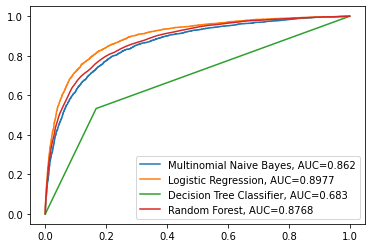

In [43]:
nb_precision_imbal, nb_recall_imbal, nb_accuracy_imbal = models(clf_nb,x_train,x_test, y_train,y_test,"Multinomial Naive Bayes")
lr_precision_imbal, lr_recall_imbal, lr_accuracy_imbal = models(clf_lr,x_train,x_test, y_train, y_test,"Logistic Regression")
dt_precision_imbal, dt_recall_imbal, dt_accuracy_imbal = models(clf_dt,x_train,x_test, y_train, y_test,"Decision Tree Classifier")
rf_precision_imbal, rf_recall_imbal, rf_accuracy_imbal = models(clf_rf,x_train, x_test, y_train,y_test,"Random Forest")
plt.legend()
plt.show()

### Balancing Data using Random over sampler (ROS) and Modelling using TF-Idf vectors

In [44]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(x_train, y_train)

In [45]:
print(f"Train_data Imbalanced label count:{Counter(y_train)}")
print(f"Train_data Balanced label count: {Counter(y_res)}")
print(f"Test_data Imbalanced label count{Counter(y_test)}")

Train_data Imbalanced label count:Counter({0: 25853, 1: 10165})
Train_data Balanced label count: Counter({0: 25853, 1: 25853})
Test_data Imbalanced label countCounter({0: 8592, 1: 3414})


-------------------- Multinomial Naive Bayes_ROS --------------------
Confusion Matrix
[[6923 1756]
 [ 705 2622]]

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      8679
           1       0.60      0.79      0.68      3327

    accuracy                           0.80     12006
   macro avg       0.75      0.79      0.76     12006
weighted avg       0.82      0.80      0.80     12006

-------------------- Logistic Regression_ROS --------------------
Confusion Matrix
[[7337 1342]
 [ 666 2661]]

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      8679
           1       0.66      0.80      0.73      3327

    accuracy                           0.83     12006
   macro avg       0.79      0.82      0.80     12006
weighted avg       0.85      0.83      0.84     12006

-------------------- Decision Tree Classifier_ROS --------------------
Confusion Matrix
[[7051 1628]
 [1527 1800]]

    

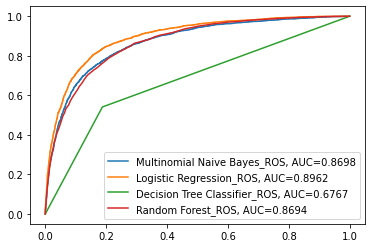

In [13]:
nb_precision_ros, nb_recall_ros, nb_accuracy_ros = models(clf_nb, X_res, x_test, y_res,y_test,"Multinomial Naive Bayes_ROS")
lr_precision_ros, lr_recall_ros, lr_accuracy_ros = models(clf_lr, X_res, x_test, y_res,y_test,"Logistic Regression_ROS", save=True)
dt_precision_ros, dt_recall_ros, dt_accuracy_ros = models(clf_dt, X_res, x_test, y_res,y_test,"Decision Tree Classifier_ROS")
rf_precision_ros, rf_recall_ros, rf_accuracy_ros = models(clf_rf, X_res, x_test, y_res,y_test,"Random Forest_ROS")
plt.legend()
plt.show()

### Balancing Data using SMOTE and Modelling using TF-Idf vectors

In [14]:
X_res, y_res = SMOTE().fit_resample(x_train, y_train)

-------------------- Multinomial Naive Bayes --------------------
Confusion Matrix
[[6943 1736]
 [ 713 2614]]

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      8679
           1       0.60      0.79      0.68      3327

    accuracy                           0.80     12006
   macro avg       0.75      0.79      0.77     12006
weighted avg       0.82      0.80      0.80     12006

-------------------- Logistic Regression --------------------
Confusion Matrix
[[7315 1364]
 [ 709 2618]]

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      8679
           1       0.66      0.79      0.72      3327

    accuracy                           0.83     12006
   macro avg       0.78      0.81      0.80     12006
weighted avg       0.84      0.83      0.83     12006

-------------------- Decision Tree Classifier --------------------
Confusion Matrix
[[6945 1734]
 [1415 1912]]

              pr

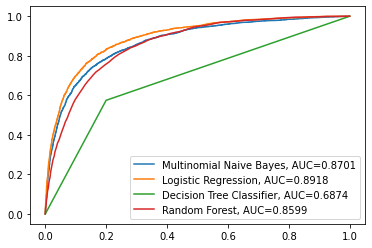

In [15]:
# models(clf_svc,X_res, y_res,"LinearSVC")
nb_precision_smote, nb_recall_smote, nb_accuracy_smote = models(clf_nb, X_res, x_test, y_res, y_test,"Multinomial Naive Bayes")
lr_precision_smote, lr_recall_smote, lr_accuracy_smote = models(clf_lr, X_res, x_test, y_res, y_test,"Logistic Regression")
dt_precision_smote, dt_recall_smote, dt_accuracy_smote = models(clf_dt, X_res, x_test, y_res,y_test,"Decision Tree Classifier")
rf_precision_smote, rf_recall_smote, rf_accuracy_smote = models(clf_rf, X_res, x_test, y_res,y_test, "Random Forest")
plt.legend()
plt.show()

### Balancing Data using ADASYN and Modelling using TF-Idf vectors

In [16]:
X_res, y_res = ADASYN().fit_resample(x_train, y_train)

-------------------- Multinomial Naive Bayes --------------------
Confusion Matrix
[[6666 2013]
 [ 621 2706]]

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      8679
           1       0.57      0.81      0.67      3327

    accuracy                           0.78     12006
   macro avg       0.74      0.79      0.75     12006
weighted avg       0.82      0.78      0.79     12006

-------------------- Logistic Regression --------------------
Confusion Matrix
[[7209 1470]
 [ 654 2673]]

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      8679
           1       0.65      0.80      0.72      3327

    accuracy                           0.82     12006
   macro avg       0.78      0.82      0.79     12006
weighted avg       0.84      0.82      0.83     12006

-------------------- Decision Tree Classifier --------------------
Confusion Matrix
[[6898 1781]
 [1466 1861]]

              pr

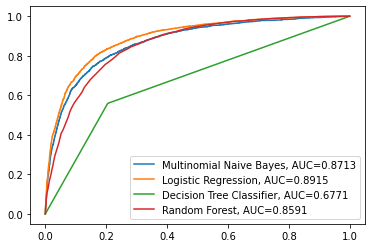

In [17]:
nb_precision_adasyn, nb_recall_adasyn, nb_accuracy_adasyn = models(clf_nb, X_res, x_test, y_res,y_test,"Multinomial Naive Bayes")
lr_precision_adasyn, lr_recall_adasyn, lr_accuracy_adasyn = models(clf_lr, X_res, x_test, y_res,y_test,"Logistic Regression")
dt_precision_adasyn, dt_recall_adasyn, dt_accuracy_adasyn = models(clf_dt, X_res, x_test, y_res,y_test,"Decision Tree Classifier")
rf_precision_adasyn, rf_recall_adasyn, rf_accuracy_adasyn = models(clf_rf, X_res, x_test, y_res,y_test,"Random Forest")
plt.legend()
plt.show()

### Result Visualization


In [24]:
# Dictionary 
nb = {  "Precision":{
         "Imbalanced" : nb_precision_imbal,
         "Balanced_ROS" : nb_precision_ros,
         "Balanced_SMOTE" : nb_precision_smote,
         "Balanced_ADASYN" : nb_precision_adasyn,
        },
      
        "Recall" :{
         "Imbalanced" : nb_recall_imbal, 
         "Balanced_ROS" : nb_recall_ros,
         "Balanced_SMOTE" : nb_recall_smote,
         "Balanced_ADASYN" : nb_recall_adasyn 
        },
      
        "Accuracy" :{
          "Imbalanced" : nb_accuracy_imbal, 
          "Balanced_ROS" : nb_accuracy_ros,
          "Balanced_SMOTE" : nb_accuracy_smote,
          "Balanced_ADASYN" : nb_accuracy_adasyn 
          }
}

lr = {  "Precision":{
         "Imbalanced" : lr_precision_imbal,
         "Balanced_ROS" : lr_precision_ros,
         "Balanced_SMOTE" : lr_precision_smote,
         "Balanced_ADASYN" : lr_precision_adasyn,
        },
      
        "Recall" :{
         "Imbalanced" : lr_recall_imbal, 
         "Balanced_ROS" : lr_recall_ros,
         "Balanced_SMOTE" : lr_recall_smote,
         "Balanced_ADASYN" : lr_recall_adasyn 
        },
      
        "Accuracy" :{
          "Imbalanced" : lr_accuracy_imbal, 
          "Balanced_ROS" : lr_accuracy_ros,
          "Balanced_SMOTE" : lr_accuracy_smote,
          "Balanced_ADASYN" : lr_accuracy_adasyn 
          }
}

dt = {  "Precision":{
         "Imbalanced" : dt_precision_imbal,
         "Balanced_ROS" : dt_precision_ros,
         "Balanced_SMOTE" : dt_precision_smote,
         "Balanced_ADASYN" : dt_precision_adasyn,
        },
      
        "Recall" :{
         "Imbalanced" : dt_recall_imbal, 
         "Balanced_ROS" : dt_recall_ros,
         "Balanced_SMOTE" : dt_recall_smote,
         "Balanced_ADASYN" : dt_recall_adasyn 
        },
      
        "Accuracy" :{
          "Imbalanced" : dt_accuracy_imbal, 
          "Balanced_ROS" : dt_accuracy_ros,
          "Balanced_SMOTE" : dt_accuracy_smote,
          "Balanced_ADASYN" : dt_accuracy_adasyn 
          }
}

rf = {  "Precision":{
         "Imbalanced" : rf_precision_imbal,
         "Balanced_ROS" : rf_precision_ros,
         "Balanced_SMOTE" : rf_precision_smote,
         "Balanced_ADASYN" : rf_precision_adasyn,
        },
      
        "Recall" :{
         "Imbalanced" : rf_recall_imbal, 
         "Balanced_ROS" : rf_recall_ros,
         "Balanced_SMOTE" : rf_recall_smote,
         "Balanced_ADASYN" : rf_recall_adasyn 
        },
      
        "Accuracy" :{
          "Imbalanced" : rf_accuracy_imbal, 
          "Balanced_ROS" : rf_accuracy_ros,
          "Balanced_SMOTE" : rf_accuracy_smote,
          "Balanced_ADASYN" : rf_accuracy_adasyn 
          }
}


In [25]:
df_nb = pd.DataFrame(nb)
df_lr = pd.DataFrame(lr)
df_dt = pd.DataFrame(dt)
df_rf = pd.DataFrame(rf)


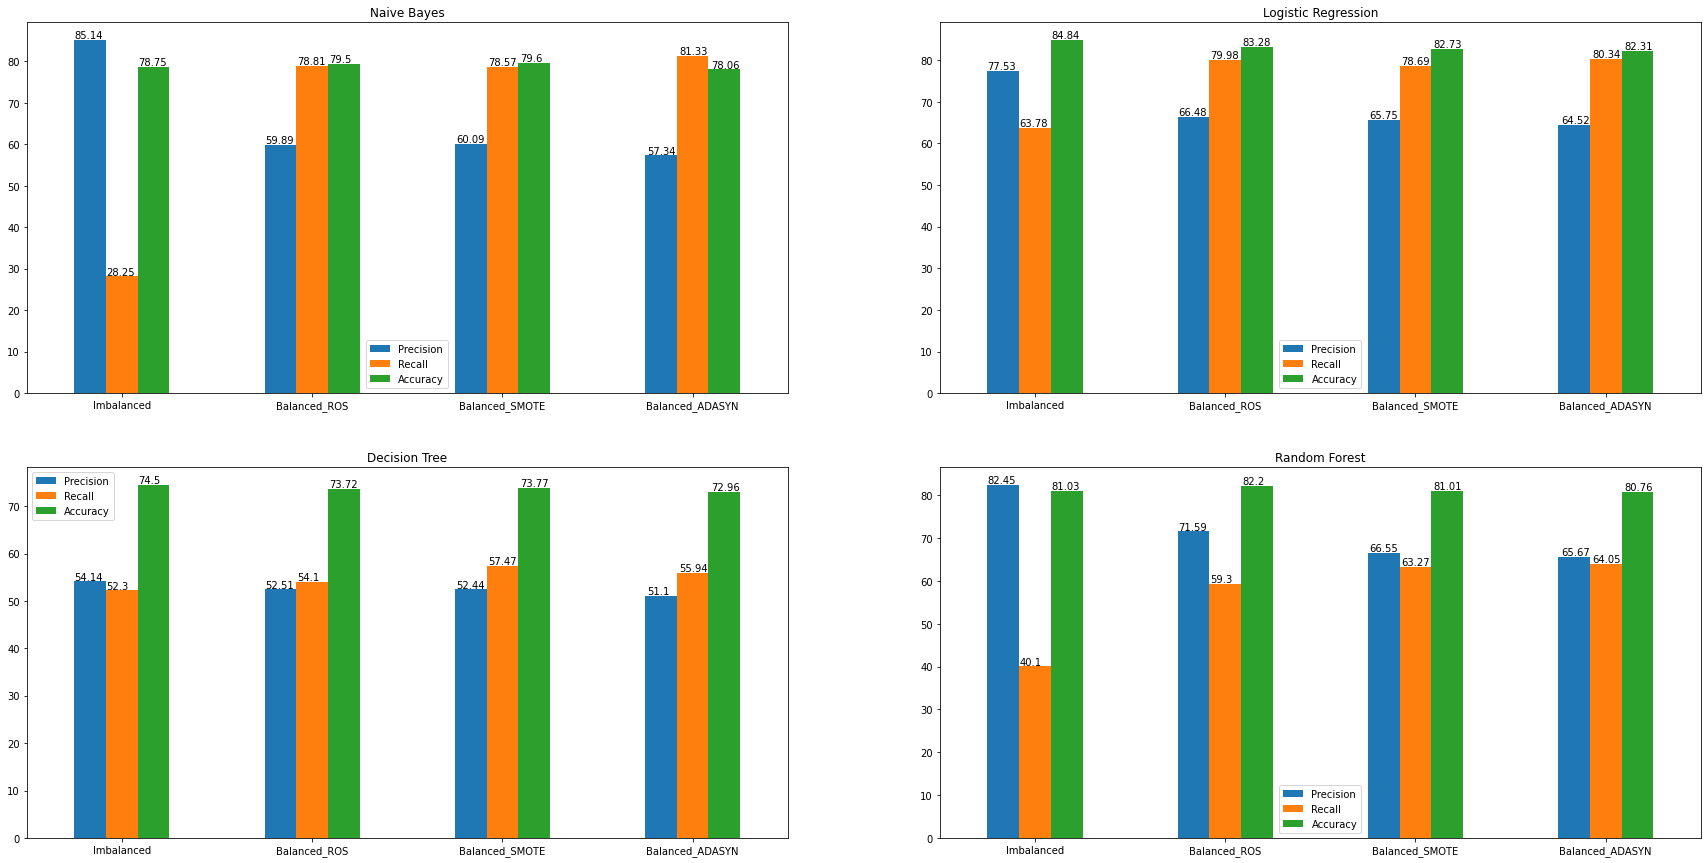

In [26]:
fig, (ax1) =  plt.subplots(2, 2, figsize=(30,15)) 
df_nb.plot.bar(ax = ax1[0,0], rot = 0, title='Naive Bayes')
df_lr.plot.bar(ax = ax1[0,1], rot = 0, title= "Logistic Regression")
df_dt.plot.bar(ax = ax1[1,0], rot = 0, title = "Decision Tree")
df_rf.plot.bar(ax = ax1[1,1], rot = 0, title = "Random Forest")

for i in range(2):
  for j in range(2):
    for p in ax1[i,j].patches:
        ax1[i,j].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()